# IMEX-RB: A Fast and Stable Time Integration Method


In [2]:
import sys
import os

# Go two levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

In [3]:
import numpy as np
import scipy
from src.imexrb import imexrb
from src.euler import backward_euler, forward_euler
import utils.mpl_pubstyle
from utils.errors import compute_errors
from utils.helpers import *

09:41:18 - matplotlib - DEBUG - matplotlib data path: /home/francesco/anaconda3/envs/imexrb-FD/lib/python3.13/site-packages/matplotlib/mpl-data
09:41:18 - matplotlib - DEBUG - CONFIGDIR=/home/francesco/.config/matplotlib
09:41:18 - matplotlib - DEBUG - interactive is False
09:41:18 - matplotlib - DEBUG - platform is linux


## Solving the 2D Viscous Burgers Equation

We seek $\mathbf{u}(\mathbf{x},t) = [u(\mathbf{x},t),\,v(\mathbf{x},t)]^T$ such that

$$
\begin{cases}
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u}\cdot\nabla)\,\mathbf{u}
= \nu\,\Delta \mathbf{u}, & \mathbf{x}\in\Omega,\; t\in(0,T],\\[0.5em]
\mathbf{u}(\mathbf{x},0) = \mathbf{u}_0(\mathbf{x}), & \mathbf{x}\in\Omega,\\[0.5em]
\mathbf{u}(\mathbf{x},t) = \mathbf{g}(\mathbf{x},t), & \mathbf{x}\in\partial\Omega,\; t\in(0,T].
\end{cases}
$$

Here $u$ and $v$ are the velocity components in $x$ and $y$, $\nu$ is the kinematic viscosity, and $\mathbf{g}$ is the Dirichlet boundary data. We consider a standard benchmark with known analytical solution \cite{BAHADIR2003131,YANG2021510}:

$$
\mathbf{u}_{\mathrm{ex}}(\mathbf{x},t)
= \frac{3}{4}\,\begin{bmatrix}1\\1\end{bmatrix}
- \frac{1}{4}\,
\begin{bmatrix}
\bigl[1 + \exp\bigl(\tfrac{-4x + 4y - t}{1/(32\nu)}\bigr)\bigr]^{-1}\\[0.5em]
-\bigl[1 + \exp\bigl(\tfrac{-4x + 4y - t}{1/(32\nu)}\bigr)\bigr]^{-1}
\end{bmatrix}.
$$

---

We then integrate in time and compare the performance of IMEX‐RB against classic first‐order schemes (Backward and Forward Euler).


In [5]:
from src.problemsPDE import Burgers2D

problem_name = "Burgers2D"
Lx = 1
Ly = Lx
Nx = 40
Ny = Nx
mu = 0.01
t0 = 0.0
tf = 1.0
tspan = [t0, tf]
# Define the problem object
problem = Burgers2D(Nx, Ny, Lx, Ly, mu)
u0 = problem.initial_condition()


We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [ ]:
# Define number of timesteps
Nt = 100
# Define epsilon for absolute stability condition
epsilon = 9e-3 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = 10
# Define max allowed enlargement during subiterations
maxsubiter = 30

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [12]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}"
      f"\nThe full order problem has dim = {problem.Nh}")

The subspace has an initial dim = 10, and such dim can grow up to 40
The full order problem has dim = 3200


We now integrate over time. We cannot know a priori the $\Delta t$ necessary for the stability of forward Euler.

In [13]:
# First, IMEX-RB
uBE, *_ = backward_euler(problem, u0, tspan, Nt)
uIMEX, tvec, subiter = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)

# Forward Euler may throw errors if unstable
uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, 5*Nt)

09:43:37 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/100


### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

09:43:40 - matplotlib.texmanager - DEBUG - family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: 
09:43:40 - matplotlib.texmanager - DEBUG - family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans
09:43:40 - matplotlib.texmanager - DEBUG - family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile
09:43:40 - matplotlib.texmanager - DEBUG - family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono
09:43:40 - matplotlib.dviread - DEBUG - Dvi: /home/francesco/.cache/matplotlib/tex.cache/39/ef/39ef863c47a658fcf7a438b6cbd8fdb4.dvi
09:43:40 - matplotlib.dviread - DEBUG - Dvi._xxx: encountered special: header=l3backend-dvips.pro
09:43:40 - matplotlib.dviread - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
09:43:40 - matplotlib.texmanager - DEBUG

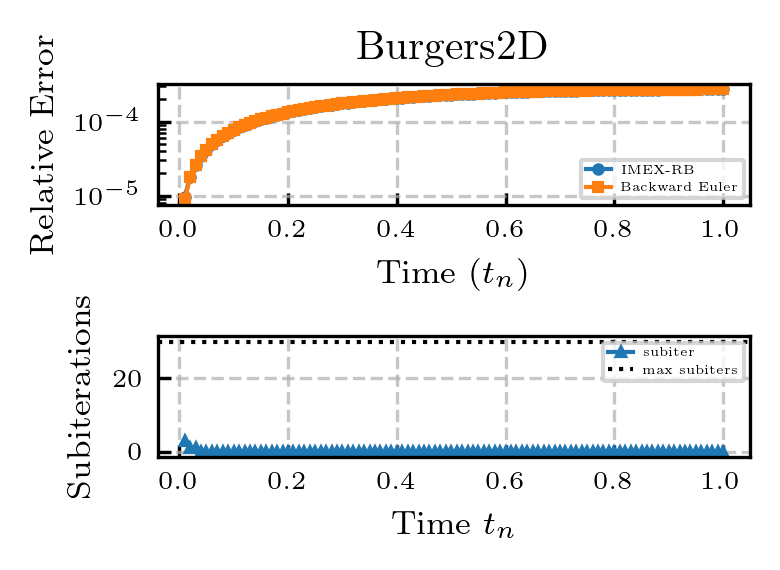

In [14]:
import matplotlib.pyplot as plt

# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem)
errBE = compute_errors(uBE, tvec, problem)
errFE = compute_errors(uFE, tvecFE, problem)

# Plot the errors
fig = plt.subplot(2,1, 1)
plt.semilogy(tvec[1:], errIMEX[0, :], label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE[0, :], label="Backward Euler", marker='s')
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

plt.xlabel(r"Time $(t_n)$")
plt.ylabel("Relative Error")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)


plt.subplot(2,1,2)
plt.plot(tvec[1:], subiter, label="subiter", marker="^")
plt.xlabel(r"Time $t_n$")
plt.ylabel(r"Subiterations")
plt.axhline(maxsubiter, linestyle=":", color="k", label=r"max subiters")
plt.legend()

plt.show()



### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

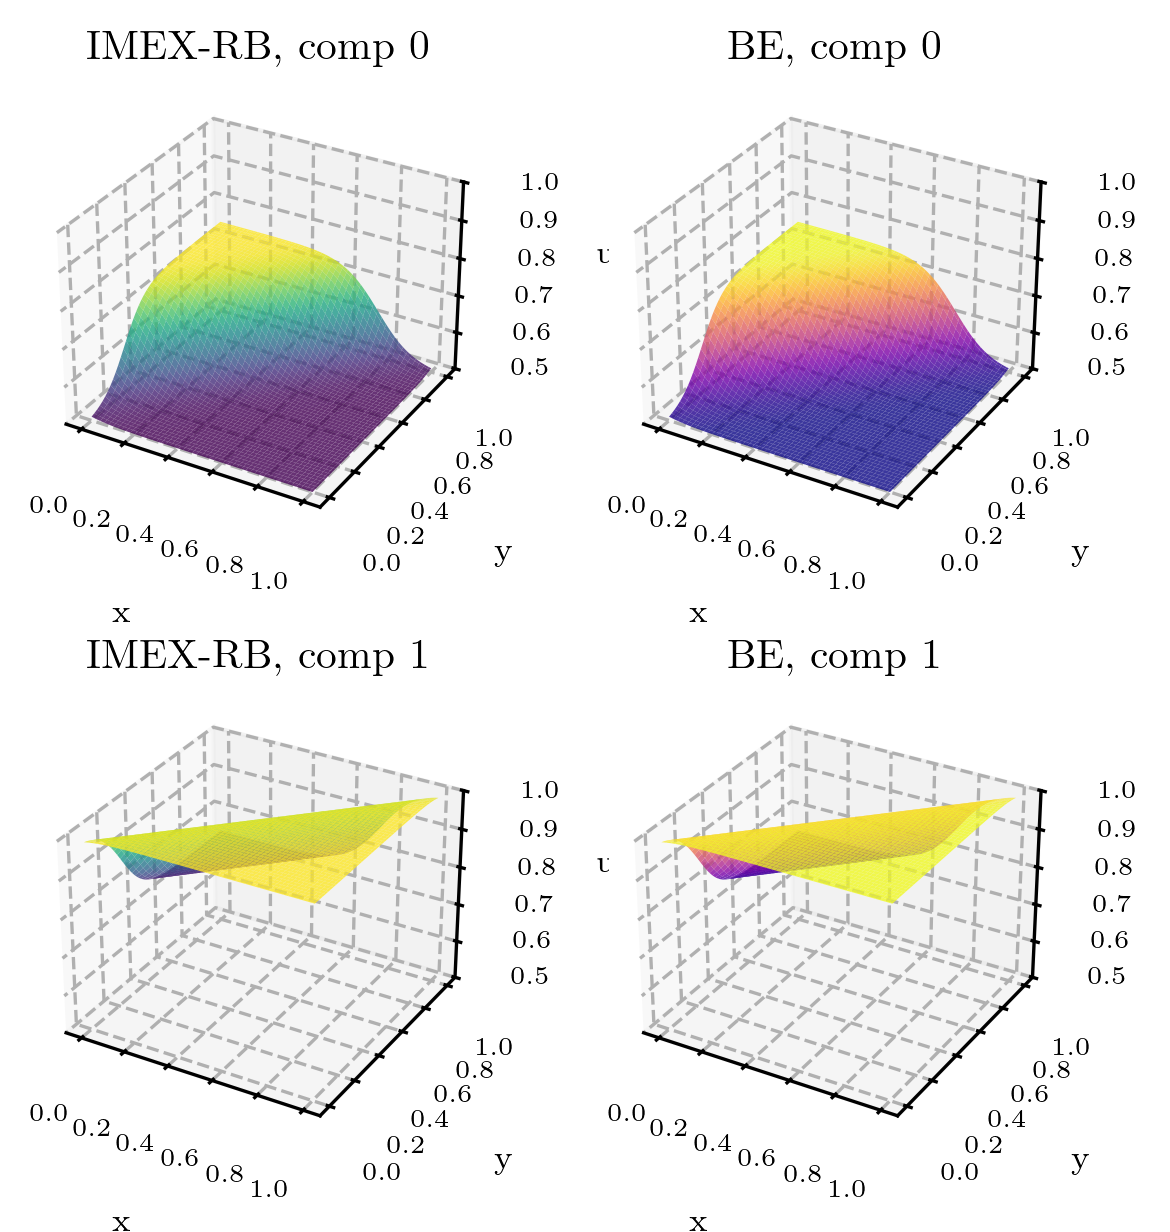

In [8]:
%matplotlib ipympl
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

X, Y = problem.coords  # X varies over columns, Y varies over rows
Nx, Ny = problem.shape  
sdim = problem.soldim

zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

fig, axes = plt.subplots(sdim, 2, figsize=(4, 3*sdim),
                         subplot_kw={'projection': '3d'})

if sdim == 1:
    axes = np.array([axes])

# Set up display for animation
display_id = display.display("", display_id=True)

# Set up axis labels and limits
for comp in range(sdim):
    for j, title in enumerate(("IMEX-RB", "BE")):
        ax = axes[comp, j]
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel(f"u[{comp}]")
        ax.set_zlim(zmin, zmax)
        ax.set_title(f"{title}, comp {comp}")


surfs = [[None]*2 for _ in range(sdim)]
for comp in range(sdim):
    for j in (0, 1):
        surfs[comp][j] = axes[comp, j].plot_surface(
            X, Y, 
            np.zeros(problem.pyshape), 
            cmap="viridis" if j == 0 else "plasma",
            alpha=0.8
        )

for n in range(uIMEX.shape[1])[::5]:  # Plot every 10th step
    for comp in range(sdim):
        # Get the data for this component
        start = comp * (Nx * Ny)
        end = (comp + 1) * (Nx * Ny)
        
        # Reshape
        Z1 = uIMEX[start:end, n].reshape(problem.pyshape)
        Z2 = uBE[start:end, n].reshape(problem.pyshape)
        
        # Update surface plots
        for j, Z in enumerate((Z1, Z2)):
            surfs[comp][j].remove()
            surfs[comp][j] = axes[comp, j].plot_surface(
                X,Y,
                Z,
                cmap="viridis" if j == 0 else "plasma",
                alpha=0.8
            )
    
    # Update the display
    display_id.update(fig)

plt.close(fig)



Go back to `matplotlib inline` (after animation)

In [9]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [10]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = [2**n for n in range(2, 8)]
errors_imex = []
errors_be = []
# errors_fe = []

# Loop over Nt values
for Nt in Nt_values:
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt, solverchoice='directsparse')
    # uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem, finaltimeonly=True)
    err_be = compute_errors(uBE, tvec, problem, finaltimeonly=True)
    # err_fe = compute_errors(uFE, tvec, problem)

    # Store the final error
    errors_imex.append(err_imex[0, -1])
    errors_be.append(err_be[0, -1])
    # errors_fe.append(err_fe[-1])



IMEX-RB: stability condition NOT met (times/total):4/4
IMEX-RB: stability condition NOT met (times/total):8/8
IMEX-RB: stability condition NOT met (times/total):3/16
IMEX-RB: stability condition NOT met (times/total):0/32
IMEX-RB: stability condition NOT met (times/total):0/64
IMEX-RB: stability condition NOT met (times/total):0/128


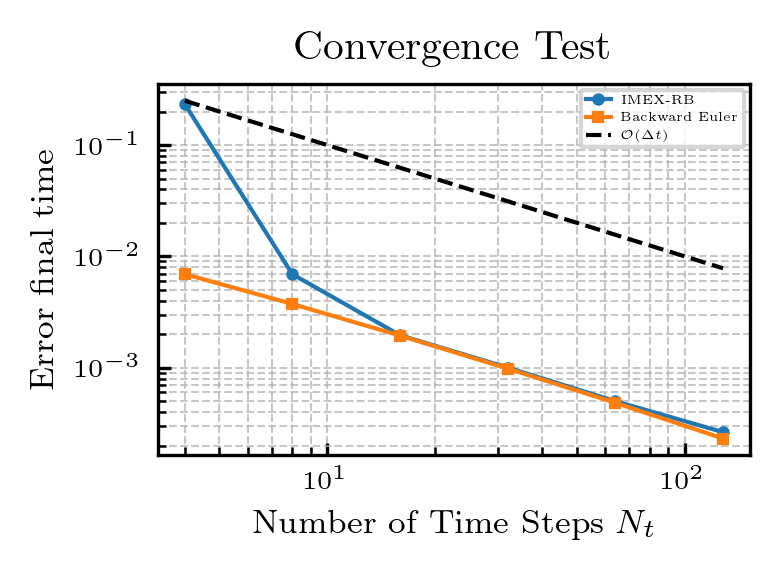

In [11]:
# Plot the convergence results
plt.loglog(Nt_values, errors_imex, label="IMEX-RB", marker='o', linestyle='-')
plt.loglog(Nt_values, errors_be, label="Backward Euler", marker='s', linestyle='-')
# plt.loglog(Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
# plt.axvline(Nt_FE_stable, label="Stability FE", color="r", linestyle=':') 
plt.loglog(Nt_values, [1/Nt for Nt in Nt_values], label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--')
plt.xlabel(r"Number of Time Steps $N_t$")
plt.ylabel("Error final time")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size

In [12]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-4 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(Nx, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

In [13]:
# Lists to store CPU times and errors
Nh_list = []
CPU_IMEX_list = []
CPU_BE_list = []
CPU_FE_list = []

err_IMEX_list = []
err_BE_list = []
err_FE_list = []

# Loop over different spatial resolutions
Nx_values = [2**val for val in range(4, 8)]
for Nx in Nx_values:
    # Define the problem object
    Ny = Nx
    problem = Burgers2D(Nx, Ny, Lx, Ly, mu)
    print(f"Running simulation for Nh = {problem.Nh}")
    Nh_list.append(problem.Nh)

    u0 = problem.initial_condition()
    epsilon = 1e-4  # tolerance parameter
    maxsize = int(np.ceil(np.power(Nx, 1/3)))
    maxsubiter = maxsize

    # Run IMEX-RB integration
    uIMEX, tvec, subiter, CPUtimeIMEX = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    # Run Backward Euler integration
    uBE, _, CPUTimeBE = backward_euler(problem, u0, tspan, Nt)
    # Run Forward Euler integration on its own stable time grid
    # Nt_FE = compute_steps_stability_FE(problem, tspan)
    uFE, tvec_FE, CPUTimeFE = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time
    err_IMEX = compute_errors(uIMEX, tvec, problem, finaltimeonly=True)
    err_BE = compute_errors(uBE, tvec, problem, finaltimeonly=True)
    err_FE = compute_errors(uFE, tvec_FE, problem, finaltimeonly=True)

    # Append CPU times and errors
    CPU_IMEX_list.append(CPUtimeIMEX)
    CPU_BE_list.append(CPUTimeBE)
    CPU_FE_list.append(CPUTimeFE)

    # Take errors on first component (arbitrarily)
    err_IMEX_list.append(err_IMEX[0])
    err_BE_list.append(err_BE[0])
    err_FE_list.append(err_FE[0])


Running simulation for Nh = 512
IMEX-RB: stability condition NOT met (times/total):0/200
Running simulation for Nh = 2048
IMEX-RB: stability condition NOT met (times/total):0/200
Running simulation for Nh = 8192
IMEX-RB: stability condition NOT met (times/total):0/200
Running simulation for Nh = 32768
IMEX-RB: stability condition NOT met (times/total):0/200


/home/francesco/Desktop/EPFL_RESEARCH/Paper1/FD-PyIMEX-RB/src/problemsPDE.py:372: RuntimeWarning: invalid value encountered in subtract
  return self.A_diff @ x - self.Cadv(x) @ x + self.source_term(t)
/home/francesco/Desktop/EPFL_RESEARCH/Paper1/FD-PyIMEX-RB/src/euler.py:31: RuntimeWarning: invalid value encountered in add
  unp1 = un + dt * problem.rhs(tvec[n], un)


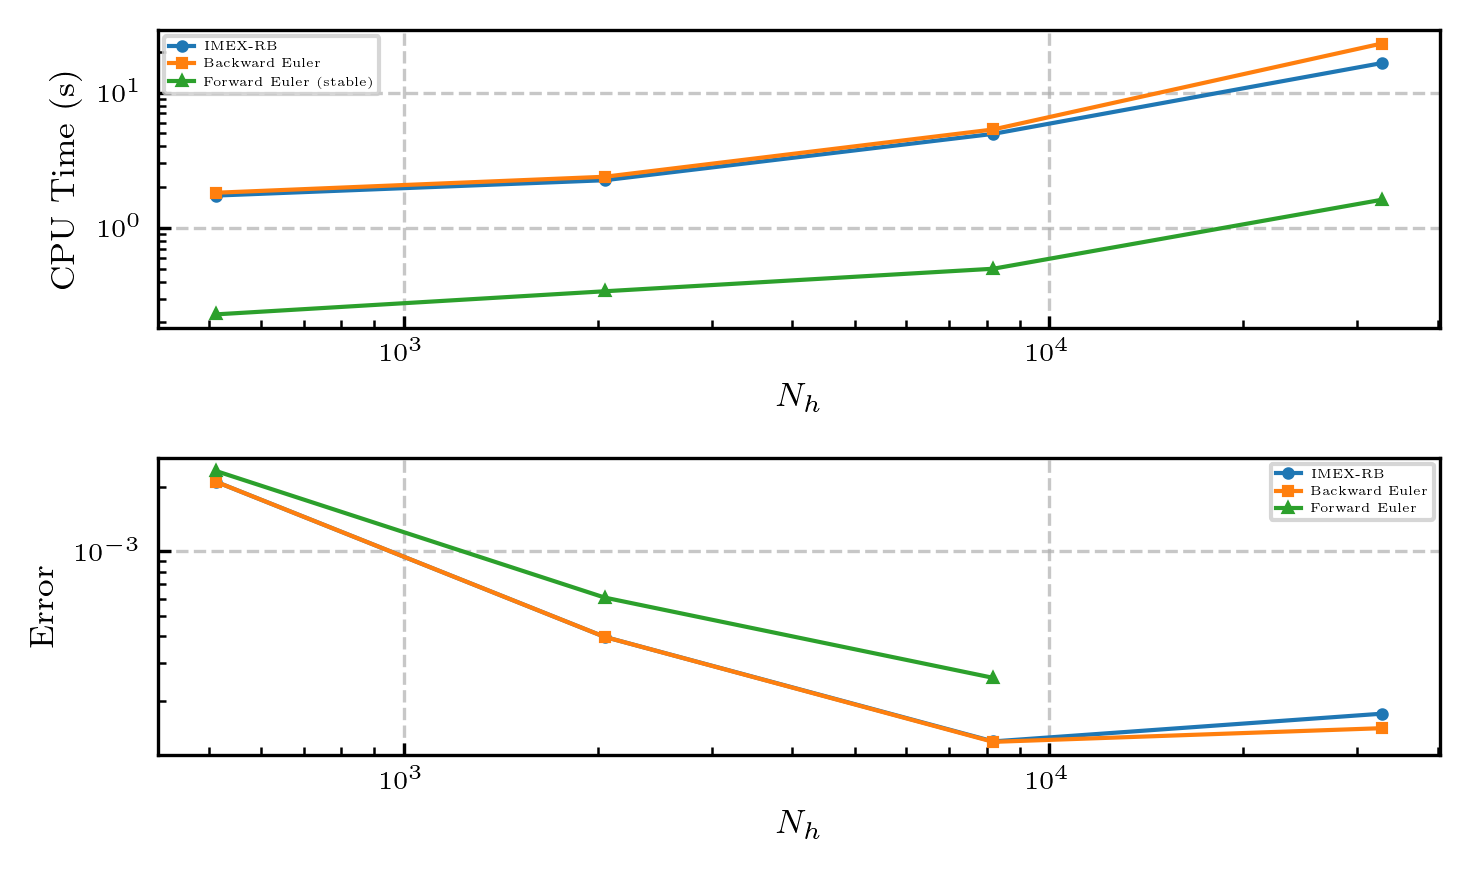

In [15]:
# Plotting CPU times vs Nx
plt.figure(figsize=(5,3))
plt.subplot(2, 1, 1)
plt.loglog(Nh_list, CPU_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_list, CPU_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_list, CPU_FE_list, '^-', label='Forward Euler (stable)')
plt.xlabel(r'$N_h$')
plt.ylabel('CPU Time (s)')
# plt.title('CPU Time vs Spatial Resolution')
plt.legend()
plt.grid(True)

# Plotting errors at final time vs Nx
plt.subplot(2, 1, 2)
plt.loglog(Nh_list, err_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_list, err_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_list, err_FE_list, '^-', label='Forward Euler')
plt.xlabel(r'$N_h$')
plt.ylabel(r'Error')
# plt.title('Error vs num of unknowns')
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.show()

Once again Forward Euler is more precise because it is forced to use smaller $\Delta t$ s to meet stability requirements